In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [3]:
import os
import math
import time
import itertools
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from data.othello import Othello, OthelloBoardState, permit_reverse
from mingpt.dataset import CharDataset
from mingpt.utils import sample
from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig

### Util functions

In [4]:
def load_othello_model(ckpt):
    # original OthelloGPT params: n_layer=8, n_head=8, n_embd=512
    # vocab_size = 59, block_size = 61 for othello
    mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
    model = GPT(mconf)
    load_res = model.load_state_dict(torch.load(f"./ckpts/{ckpt}.ckpt"))
    if torch.cuda.is_available():
        device = torch.cuda.current_device()
        model = model.to(device)
        return model, device
    else:
        print("NO GPU FOUND")

In [9]:
def draw_heatmap(token_pred, **kwargs):
    # take off first token, as it isn't a board position
    token_pred = token_pred[1:]
    # add padding to get from tokens -> board positions
    padding = np.zeros(2)
    board = np.concatenate([token_pred[:27], padding, token_pred[27:33], padding, token_pred[33:]], axis=0)
    # plotting
    fig = plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    sns.heatmap(board.reshape(8, 8), **kwargs,
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")
    return fig

### Legal move validation

In [16]:
def quick_validate(model_ckpt, dataset, n_games=1000, quiet=False):
    othello = Othello(data_root=dataset, n_games=n_games, test_split=0, deduplicate=False, quiet=quiet)
    train_dataset = CharDataset(othello, quiet=quiet)
    loader = DataLoader(train_dataset, shuffle=False, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    total_nodes = 0
    success_nodes = 0
    def progress_report():
        return f"{success_nodes/total_nodes*100:.4f}% pass rate: {success_nodes}/{total_nodes} among all searched nodes"

    all_pred = np.zeros((0, 59))

    for it, (x, y) in enumerate(loader):
        x = x.to(device)
        logits, _ = model(x)
        pred = torch.argmax(logits, dim=2).detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup)]

        all_pred = np.concatenate((all_pred, pred), axis=0)

    bar = tqdm(othello, disable=quiet)
    for i_seq, seq in enumerate(bar):
        if -100 in seq:
            seq = seq[:seq.index(-100)]

        for len_partial in range(1, len(seq)):
            total_nodes += 1
            context = seq[:len_partial]
            completion = train_dataset.itos[int(all_pred[i_seq][len_partial-1])]
            context.append(completion)
            try:
                OthelloBoardState().update(context)
            except Exception:
                # print(completion)
                pass
            else:
                success_nodes += 1
        
        bar.set_description(progress_report())

    return success_nodes, total_nodes

In [19]:
# models = ["control", "bias50", "bias80", "bias95"]
# datasets = ["synthetic", "TLbias50", "TLbias80", "TLbias95"]
models = [f"ft_bias50_1k__20230712_202339_e{i}" for i in [1, 5, 10, 20, 50]]
datasets = ["synthetic"]

for m in models:
    acc = []
    for d in datasets:
        print(m, d)
        sn, tn = quick_validate(m, f"othello_{d}", n_games=1000, quiet=True)
        acc.append(sn / tn)
    print(", ".join([str(x) for x in acc]))


ft_bias50_1k__20230712_202339_e1 synthetic
0.9893959959280625
ft_bias50_1k__20230712_202339_e5 synthetic
0.9890736342042755
ft_bias50_1k__20230712_202339_e10 synthetic
0.9891923990498812
ft_bias50_1k__20230712_202339_e20 synthetic
0.9886834068544282
ft_bias50_1k__20230712_202339_e50 synthetic
0.9881913810654903


### Illegal probability mass

In [ ]:
# calculating illegal probability share
othello = Othello(data_root="othello_TLbias80", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)
loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

model, device = load_othello_model("bias/TLbias50")

In [5]:
def calc_batched_pred(model_ckpt, dataset):
    othello = Othello(data_root=dataset, n_games=10000, test_split=0, deduplicate=False)
    train_dataset = CharDataset(othello)
    loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                    batch_size=64,
                                    num_workers=0)

    model, device = load_othello_model(model_ckpt)

    # device = torch.cuda.current_device()
    stoi = np.vectorize(train_dataset.stoi.get) # othello move to token
    itos = np.vectorize(train_dataset.itos.get) # token to othello move

    batched_pred = np.zeros((59, 61))

    for x, y in tqdm(loader):
        # saving board positions for updating game state
        moves = x.numpy()
        moves = itos(moves)

        x = x.to(device)  # [B, T]
        y = y.to(device)  # [B, T]
        logits, loss = model(x, y)
        
        logits = torch.softmax(logits, dim=2)
        pred = logits.detach().cpu().numpy()
        # pred is [batch size, block_size (59 for normal othello setup), vocab_size (61 for normal othello setup)]
        # print(pred.shape)

        legal_mask = np.zeros(pred.shape)
        for game in range(pred.shape[0]):
            ob = OthelloBoardState()
            # print(moves[game])
            for i, m in enumerate(moves[game]):
                if m == -100:
                    break
                ob.update([m])
                valid = ob.get_valid_moves()
                if valid:
                    legal_mask[game, i, stoi(valid)] = 1

        # legal_prob = pred * legal_mask
        illegal_prob = pred * (1 - legal_mask)

        np.add(batched_pred, illegal_prob.sum(axis=0), out=batched_pred)

    return batched_pred

In [ ]:
to_save = {}
for c in ["control", "bias50", "bias80", "bias95"]:
    for dr in ["synthetic", "TLbias50", "TLbias80", "TLbias95"]:
        print(f"======== ckpt: {c} | data: {dr} =========")
        arr = calc_batched_pred(f"bias/TL{c}", f"othello_{dr}")
        to_save[f"{c}_{dr}"] = arr

np.savez('illegal_move_mass.npz', **to_save)
        

In [18]:
raw = np.load("visuals/data/illegal_move_mass10k.npz")

data = {}
for k,v in raw.items():
    model, dataset = k.split("_")
    if model not in data:
        data[model] = {}
    data[model][dataset] = v.sum(axis=1)

print(data.keys())
print(data['control'].keys())

dict_keys(['control', 'bias50', 'bias80', 'bias95'])
dict_keys(['synthetic', 'TLbias50', 'TLbias80', 'TLbias95'])


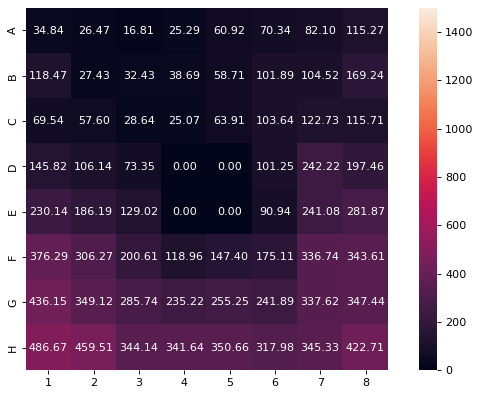

In [17]:
fig = draw_heatmap(data["bias50"]["TLbias50"], vmax=1500)

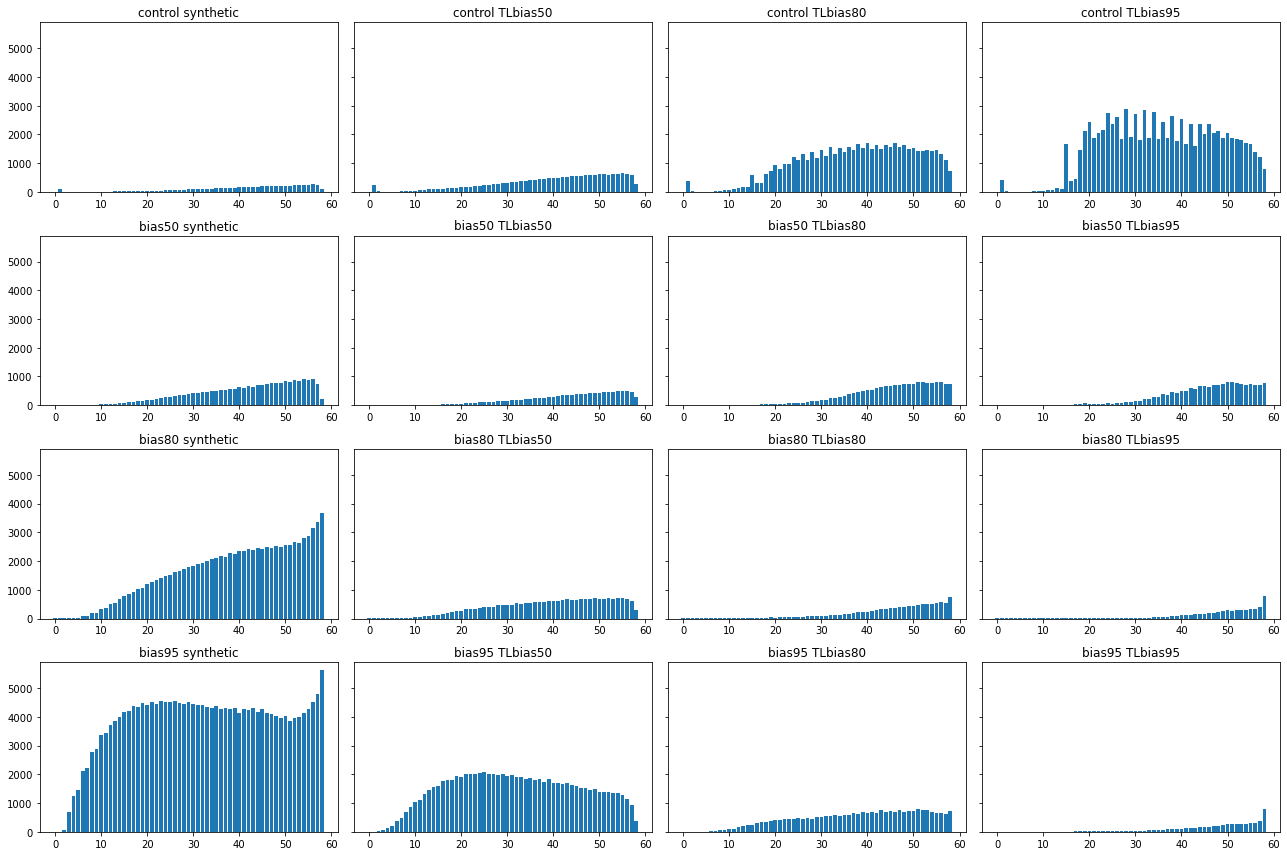

In [19]:
# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(18, 12), sharey=True)

# Iterate over each subplot
for i, model_name in enumerate(data):
    for j, dataset_name in enumerate(data[model_name]):
        y = data[model_name][dataset_name]
        # Plot the bar chart for each subplot
        axs[i, j].bar(range(len(y)), y)
        axs[i, j].set_title(f"{model_name} {dataset_name}")

# Adjust the spacing between subplots
fig.tight_layout()

plt.show()

### Animating merged predictions

In [ ]:
# calculating aggregated predictions

model, device = load_othello_model("bias/TLbias50")

othello = Othello(data_root="othello_TLbias50", n_games=1000, test_split=0, deduplicate=False)
train_dataset = CharDataset(othello)

loader = DataLoader(train_dataset, shuffle=True, pin_memory=True,
                                batch_size=64,
                                num_workers=0)

merged_pred = np.zeros((59, 61))
device = torch.cuda.current_device()
for x, y in loader:
    x = x.to(device)  # [B, T]
    y = y.to(device)  # [B, T]
    logits, loss = model(x, y)
    
    logits = torch.softmax(logits, dim=2)
    pred = logits.detach().cpu().numpy()
    # print(pred.shape)
    batch_pred = np.sum(pred, axis=0)
    np.add(merged_pred, batch_pred, out=merged_pred)

print(merged_pred.shape)

In [ ]:
# generates an animated gif of heatmaps over the course of the game

from PIL import Image

heatmap_images = []

for move in range(merged_pred.shape[0]):
    # move_prob = merged_pred[move][1:]
    # padding = np.zeros(2)
    # board = np.concatenate([move_prob[:27], padding, move_prob[27:33], padding, move_prob[33:]], axis=0)
    
    # fig = plt.figure(figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    # sns.heatmap(board.reshape(8, 8), vmin=0, vmax=200,
    #             yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True,
    #             annot=True, fmt=".2f")
    fig = draw_heatmap(merged_pred[move])

    # Convert the heatmap plot to an image
    fig.canvas.draw()
    heatmap_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())
    heatmap_images.append(heatmap_image)

heatmap_images[0].save('heatmap_animation.gif', save_all=True, append_images=heatmap_images[1:], loop=0)

### Visualizing individual board states

In [39]:
model, device = load_othello_model("bias/TLcontrol")

In [5]:
ex_games = Othello(data_root="othello_synthetic", n_games=5, test_split=1)
train_dataset = CharDataset(ex_games.val)

Mem Used: 1.114 GB:   0%|          | 0/50 [00:00<?, ?it/s]

Loaded 100000 from 1 files
Deduplicating finished with 5 games left
Using 0 for training, 5 for validation
Dataset created has 5 sequences, 61 unique words.


In [6]:
partial_game = ex_games.val[0][:7]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25, 3]
# partial_game = [19, 18, 17, 20, 21, 12, 37, 30, 14, 43, 26, 34, 39, 38, 46, 9, 42, 33, 4, 55, 32, 13, 44, 41, 0, 25]
# partial_game = [19, 18, 17, 9, 1, 0, 26, 2, 10, 11, 3, 4, 8, 16, 37, 12, 5, 6, 13]
ob = OthelloBoardState()
ob.update(partial_game)
ob.__print__()
print([permit_reverse(x) for x in ob.get_valid_moves()])

--------------------
['e6', 'd6', 'c7', 'f5', 'c6', 'b8', 'd7']
a                
b               O
c           X O  
d       O X X X  
e       X O X    
f         O      
g                
h                
  1 2 3 4 5 6 7 8
--------------------
['c5', 'c8', 'd3', 'd8', 'e3', 'e7', 'f4']


In [19]:
# load partial game onto GPU
history = torch.tensor([train_dataset.stoi[s] for s in partial_game], dtype=torch.long).to(device)
# get model prediction
pred, _ = model(history[None, :]) 
# transform into probability for each board state
pred = pred[0, -1, 1:]
padding = torch.zeros(2).cuda()
pred = torch.softmax(pred, dim=0)
pred = torch.cat([pred[:27], padding, pred[27:33], padding, pred[33:]], dim=0)

<AxesSubplot:>

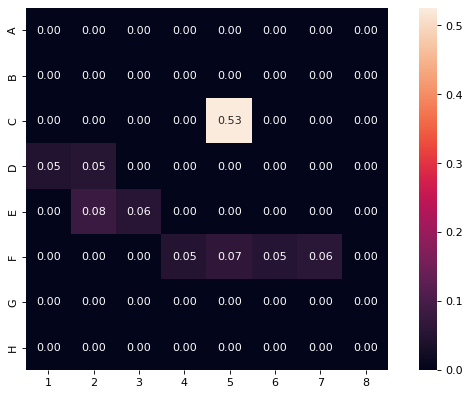

In [20]:
# plotting
fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(pred.detach().cpu().numpy().reshape(8, 8), 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")